In [1]:
from astropy import constants as const
from scipy.stats import stats
import scipy.integrate as integrate
from scipy.stats import norm
from scipy import interpolate
from astropy.io import fits
from iminuit import Minuit
from scipy.optimize import curve_fit
from iminuit.cost import LeastSquares
import numpy as np
import pysynphot as S
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["figure.figsize"] = (12,6)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [2]:
NBBANDS=6
band_to_number={'u':0,'g':1,'r':2,'i':3,'z':4,'y4':5}
band_to_number_2={'u':0,'g':1,'r':2,'i':3,'z':4,'y':5}
number_to_band={0:'u',1:'g',2:'r',3:'i',4:'z',5:'y4'}
filtercolor=['blue','green','red','orange','grey','black']
NBCOLORS=NBBANDS-1
number_to_color={0:'U-G',1:'G-R',2:'R-I',3:'I-Z',4:'Z-Y'}
color_to_number={'U-G':0,'G-R':1,'R-I':2,'I-Z':3,'Z-Y':4}
mpl_colors_col=['b','g','r','y','k']

WLMIN=3000. # Minimum wavelength : PySynPhot works with Angstrom
WLMAX=11000. # Minimum wavelength : PySynPhot works with Angstrom

NBINS=int(WLMAX-WLMIN) # Number of bins between WLMIN and WLMAX
BinWidth=(WLMAX-WLMIN)/float(NBINS) # Bin width in Angstrom
WL=np.linspace(WLMIN,WLMAX,NBINS)   # Array of wavelength in Angstrom

# LSST collectif surface
Deff=642.3 # effective radius in cm
Seff = np.pi*Deff**2/4  # in cm2
S.refs.setref(area=Seff, waveset=None) # set by default to 6.4230 m2
S.refs.set_default_waveset(minwave=WLMIN, maxwave=WLMAX, num=NBINS, delta=BinWidth, log=False)
S.refs.showref()

EXPOSURE=30.0    

graphtable: D:\PYSYN_CDBS\grp\redcat\trds\mtab\4cm1612bm_tmg.fits
 comptable: D:\PYSYN_CDBS\grp\redcat\trds\mtab\5182153pm_tmc.fits
thermtable: D:\PYSYN_CDBS\grp\redcat\trds\mtab\3241637sm_tmt.fits
      area: 324015.4546769212
   waveset: Min: 3000.0, Max: 11000.0, Num: None, Delta: 1.0, Log: False


# Cadence LMC baseline v1

In [3]:
df = pd.read_csv("Downloads\Cadences dobservation des nuages de Magellan/cadence_lmc_baseline2018a.csv", index_col=0)


# t0 distribution

Text(0.5, 1.0, 'Distribution des $t_0$')

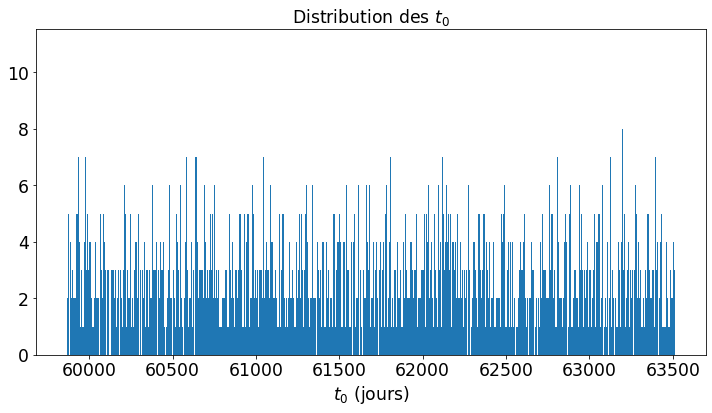

In [5]:
from scipy.stats import uniform

NYEARS = 10
NDAYS = NYEARS*365.25

xmin = 0
xmax = NDAYS
N=10000 # le nombre de simulation peut être artibrairement tres grand. Ce qui compte c'est de calculer l'efficacité de detection de la courbe de lumière
list_t0 = uniform.rvs(xmin,xmax,N) + df['observationStartMJD'][0]

plt.hist(list_t0,bins=int(NDAYS));
plt.xlabel("$t_0$ (jours)")
plt.title("Distribution des $t_0$")

# u0 distribution

Text(0.5, 1.0, 'Densité de probabilité de $u_{min}$')

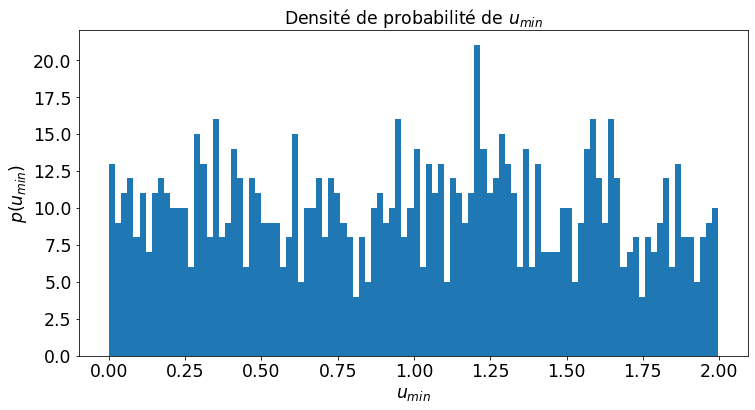

In [6]:
N = 1000
uminmin = 0
uminmax = 2
umin = uniform.rvs(uminmin,uminmax,N)

plt.hist(umin,bins=100)
plt.xlabel("$u_{min}$")
plt.ylabel("$p(u_{min})$")
plt.title("Densité de probabilité de $u_{min}$")

# Relative angular source-lens separation u(t)

$$ 
   u(t) = \sqrt{u_{0}^2 + (\frac{t-t_0}{t_E})^2)}
$$




In [7]:
def u(t):
    return np.sqrt(u0**2+ ((t-t0)/tE)**2)

# Amplitude as a function of u(t)

$$
    A(u) = \frac{u^2 + 2}{u\sqrt{u^2 + 4}}
$$

In [8]:
def A(u):
    return (u**2+2)/u/np.sqrt(u**2+4)

# Amplitude as a function of u0, t0, tE

$$
    A(t, u_0, t_0, t_E) = \frac{u_{0}^2 + (\frac{t-t_0}{t_E})^2) + 2}{\sqrt{u_{0}^2 + (\frac{t-t_0}{t_E})^2)} \sqrt{u_{0}^2 + (\frac{t-t_0}{t_E})^2) + 4}}
$$

In [9]:
def Ab(t, u0, t0, tE) :
    return ((np.sqrt(u0**2+ ((t-t0)/tE)**2))**2+2)/(np.sqrt(u0**2+ ((t-t0)/tE)**2))/np.sqrt((np.sqrt(u0**2+ ((t-t0)/tE)**2))**2+4) 

# Gaussian

$$
    y = \frac{A}{\sigma \sqrt{2\pi}} e^{\frac{-(x - \mu)^2}{2\sigma^2}}
$$

In [10]:
#Gaussian fit

def Gauss(x, A, mu ,sigma) :
    return A*np.exp(-(x-mu)**2/(2*sigma**2))/sigma/np.sqrt(2*np.pi)

# Linear 

$$
    y = \alpha x + \beta
$$


In [11]:
#Linear fit

def linear(x, alpha, beta) : 
    return alpha*x + beta

# Plotting the light curve and Microlensing fit

t0 = 59933.90916666624
tE = 200
u0 = 0.19050173272661586


(58933.90916666624, 60933.90916666624)

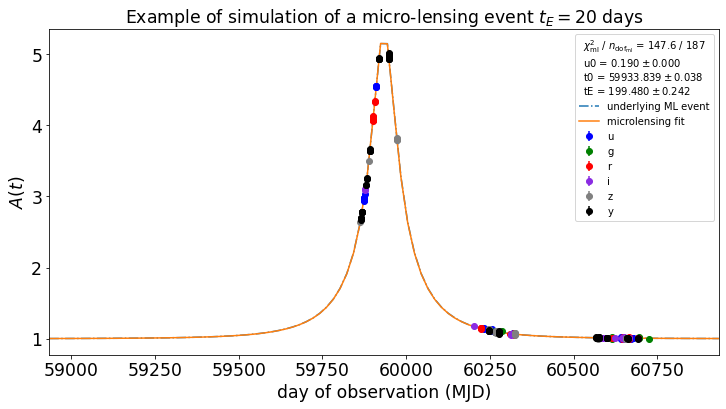

In [12]:
#Randomize parameters

from random import *

u0 = umin[randrange(len(umin))]
t0 = list_t0[randrange(len(list_t0))] 

#tE distribution or value

tE = 20

#Time t 

tmin=t0-5.*tE
tmax=t0+5.*tE
ti=np.linspace(tmin,tmax,100)


print("t0 = {}".format(t0)) #Display values
print("tE = {}".format(tE))
print("u0 = {}".format(u0))



#We distinguish data points by filter

df_event_u = df[(df["filter"] == "u") & (df["observationStartMJD"] >= tmin) & (df["observationStartMJD"] <= tmax)] 
df_event_g = df[(df["filter"] == "g") & (df["observationStartMJD"] >= tmin) & (df["observationStartMJD"] <= tmax)] 
df_event_r = df[(df["filter"] == "r") & (df["observationStartMJD"] >= tmin) & (df["observationStartMJD"] <= tmax)] 
df_event_i = df[(df["filter"] == "i") & (df["observationStartMJD"] >= tmin) & (df["observationStartMJD"] <= tmax)]  
df_event_z = df[(df["filter"] == "z") & (df["observationStartMJD"] >= tmin) & (df["observationStartMJD"] <= tmax)]  
df_event_y = df[(df["filter"] == "y") & (df["observationStartMJD"] >= tmin) & (df["observationStartMJD"] <= tmax)] 
df_event = df[(df["observationStartMJD"] >= tmin) & (df["observationStartMJD"] <= tmax)] 

df_event_times = df_event["observationStartMJD"].values
df_event_times_u = df_event_u["observationStartMJD"].values 
df_event_times_g = df_event_g["observationStartMJD"].values
df_event_times_r = df_event_r["observationStartMJD"].values
df_event_times_i = df_event_i["observationStartMJD"].values
df_event_times_z = df_event_z["observationStartMJD"].values
df_event_times_y = df_event_y["observationStartMJD"].values


#Plot

plt.plot(ti,A(u(ti)),"-.",label="underlying ML event")
#plt.scatter(df_event_times,A(u(df_event_times)),marker="o",s=20,color = "b",label="u")
#plt.scatter(df_event_u_times,A(u(df_event_u_times)),marker="o",s=20,color = "b",label="u")
#plt.scatter(df_event_g_times,A(u(df_event_g_times)),marker="o",s=20,color = "g",label="g")
#plt.scatter(df_event_r_times,A(u(df_event_r_times)),marker="o",s=20,color = "r",label="r")
#plt.scatter(df_event_i_times,A(u(df_event_i_times)),marker="o",s=20,color ="blueviolet",label="i")
#plt.scatter(df_event_z_times,A(u(df_event_z_times)),marker="o",s=20,color ="grey",label="z")
#plt.scatter(df_event_y_times,A(u(df_event_y_times)),marker="o",s=20,color="k",label="y")

# Microlensing fit with iMinuit

x = df_event_times       
x_u = df_event_times_u
x_g = df_event_times_g
x_r = df_event_times_r
x_i = df_event_times_i
x_z = df_event_times_z
x_y = df_event_times_y

y_data = A(u(df_event_times))

y_noise = 0.01

y = y_data + y_noise * np.random.randn(len(x))
y_u = A(u(df_event_times_u)) + y_noise * np.random.randn(len(x_u))
y_g = A(u(df_event_times_g)) + y_noise * np.random.randn(len(x_g))
y_r = A(u(df_event_times_r)) + y_noise * np.random.randn(len(x_r))
y_i = A(u(df_event_times_i)) + y_noise * np.random.randn(len(x_i)) 
y_z = A(u(df_event_times_z)) + y_noise * np.random.randn(len(x_z))
y_y = A(u(df_event_times_y)) + y_noise * np.random.randn(len(x_y))


plt.errorbar(x_u, y_u, y_noise, fmt="o", label="u", color = "b")  #Show data points with their respective photometric error
plt.errorbar(x_g, y_g, y_noise, fmt="o", label="g", color = "g")  #Color depends on the filter
plt.errorbar(x_r, y_r, y_noise, fmt="o", label="r", color = "r")
plt.errorbar(x_i, y_i, y_noise, fmt="o", label="i", color = "blueviolet")
plt.errorbar(x_z, y_z, y_noise, fmt="o", label="z", color ="grey")
plt.errorbar(x_y, y_y, y_noise, fmt="o", label="y", color ="k")

least_squares = LeastSquares(x, y, y_noise, Ab)        # Fit using the least squares method
m = Minuit(least_squares, u0 = u0, t0 = t0, tE = tE)  #starting values for our parameters


m.migrad() # finds minimum of least_squares function
m.hesse()  # accurately computes uncertainties

plt.plot(ti, Ab(ti, *m.values), label="microlensing fit") 


#Plot legend etc

fit_info = [
    f"$\\chi^2_\\mathrm{{ml}}$ / $n_\\mathrm{{dof_\\mathrm{{ml}}}}$ = {m.fval:.1f} / {len(x) - m.nfit}",    #Display fit info  
]
for p, v, e in zip(m.parameters, m.values, m.errors):
    fit_info.append(f"{p} = ${v:.3f} \\pm {e:.3f}$")

plt.xlabel("day of observation (MJD)")
plt.ylabel("$A(t)$")
plt.title("Example of simulation of a micro-lensing event $t_E = 20$ days")
plt.legend(title="\n".join(fit_info))
plt.xlim(tmin,tmax)

# Linear fit

(58933.90916666624, 60933.90916666624)

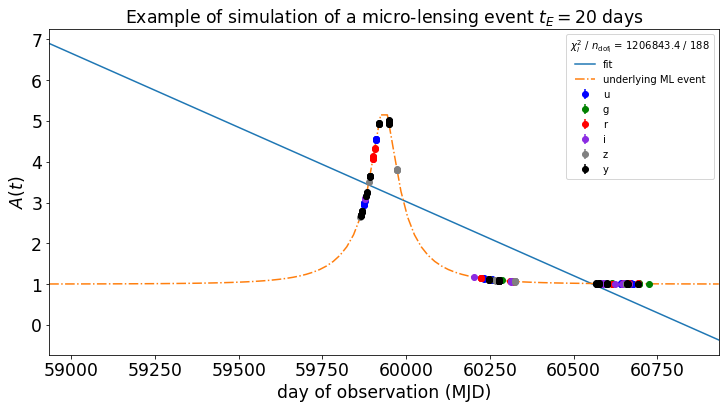

In [13]:
least_squares_line = LeastSquares(x, y, y_noise, linear) #linear least squares
m_line = Minuit(least_squares_line, alpha=1, beta=1)  

m_line.migrad() # finds minimum of least_squares function
m_line.hesse()  # accurately computes uncertainties

plt.errorbar(x_u, y_u, y_noise, fmt="o", label="u", color = "b")  #Show data points with their respective photometric error
plt.errorbar(x_g, y_g, y_noise, fmt="o", label="g", color = "g")  #Color depends on the filter
plt.errorbar(x_r, y_r, y_noise, fmt="o", label="r", color = "r")
plt.errorbar(x_i, y_i, y_noise, fmt="o", label="i", color = "blueviolet")
plt.errorbar(x_z, y_z, y_noise, fmt="o", label="z", color ="grey")
plt.errorbar(x_y, y_y, y_noise, fmt="o", label="y", color ="k")
plt.plot(ti, linear(ti, *m_line.values), label="fit")
plt.plot(ti,A(u(ti)),"-.",label="underlying ML event")


fit_info = [
    f"$\\chi^2_l$ / $n_\\mathrm{{dof_l}}$ = {m_line.fval:.1f} / {len(x) - m_line.nfit}",     #Display fit info
]
plt.xlabel("day of observation (MJD)")
plt.ylabel("$A(t)$")
plt.title("Example of simulation of a micro-lensing event $t_E = 20$ days")
plt.legend(title="\n".join(fit_info))
plt.xlim(tmin,tmax)

In [14]:
(m_line.fval - m.fval)/np.sqrt(2*(len(x)- m.nfit)) 

62396.75543543629

# Test error 

In [15]:

m = 20
xerr = []
sigma_sys = 0.003
error_photo = []


for i in range (len(df)) :
    
    xerr.append( 10**(0.4*(m - df["fiveSigmaDepth"][i])))
    
    if (df["filter"][i] == "u") :
        
        error_photo.append( np.sqrt(sigma_sys**2 + (0.04 - 0.037) * xerr[i] + 0.037 * xerr[i]**2))  
   
    elif (df["filter"][i] == "g") :
        
        error_photo.append( np.sqrt(sigma_sys**2 + (0.04 - 0.038) * xerr[i] + 0.038 * xerr[i]**2))  
        
    elif (df["filter"][i] == "r") :
        
        error_photo.append( np.sqrt(sigma_sys**2 + (0.04 - 0.039) * xerr[i] + 0.039 * xerr[i]**2))  
        
    elif (df["filter"][i] == "i") :
        
        error_photo.append( np.sqrt(sigma_sys**2 + (0.04 - 0.039) * xerr[i] + 0.039 * xerr[i]**2))      
           
    elif (df["filter"][i] == "z") :
        
        error_photo.append( np.sqrt(sigma_sys**2 + (0.04 - 0.040) * xerr[i] + 0.040 * xerr[i]**2))     
        
    elif (df["filter"][i] == "y") :
        
        error_photo.append( np.sqrt(sigma_sys**2 + (0.04 - 0.040) * xerr[i] + 0.040 * xerr[i]**2))
        


# Photo error as a function of magnitude

Text(0.5, 1.0, 'Photometric error as a function of magnitude')

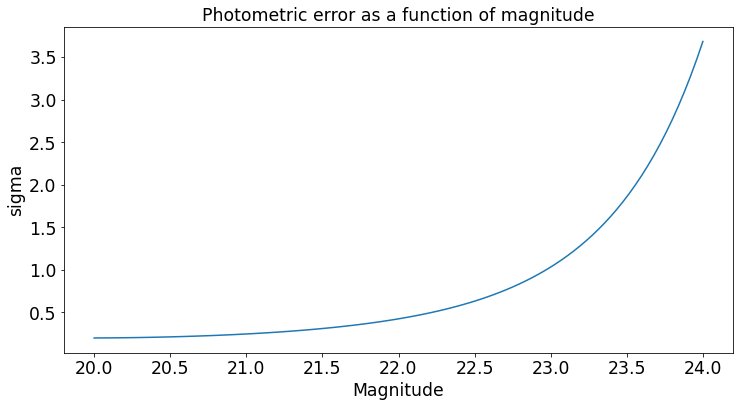

In [16]:
mag = np.linspace(20,24,100)
sigma = []

for i in range (len(mag)) :
    
    sigma.append(np.sqrt(sigma_sys**2 + (0.04 - 0.037) * 10**(0.4*(mag[i] - 20)) + 0.037 * 10**(0.4*(mag[i] - 20))**2))

    
plt.plot(mag,sigma)
plt.xlabel("Magnitude")
plt.ylabel("sigma")
plt.title("Photometric error as a function of magnitude")
#plt.text(x = 21, y = 3, s = "Low magnitude/Bright source means high photometric error", fontsize = 15, color = 'r')

# Background noise

$$
    F_b = F_{ab}10^{-0.4m_b} \times \pi \theta_{seeing}^2 
$$

$$
     F_{ab} = 3631 Jy = 3631\times10^{-23} erg.s^{-1}.Hz^{-1}.cm^{-2} = 3631\times10^{-26} W.Hz^{-1}.m^{-2}
$$

$$
    N_{pe}^b = \frac{\pi D^2 \Delta T}{4h}F_b \int_{}^{} T^{syst}_b(\lambda) \,\frac{d\lambda}{\lambda} 
$$

In [17]:
df_LSST = pd.read_csv("D:\\Projet de recherche\Stage\lsst_throughput.csv", index_col=0)

In [18]:
LSST_u = S.ArrayBandpass(df_LSST["wl"].values*10, df_LSST["u"].values, name = "u")
LSST_g = S.ArrayBandpass(df_LSST["wl"].values*10, df_LSST["g"].values, name = "g")
LSST_r = S.ArrayBandpass(df_LSST["wl"].values*10, df_LSST["r"].values, name = "r")
LSST_i = S.ArrayBandpass(df_LSST["wl"].values*10, df_LSST["i"].values, name = "i")
LSST_z = S.ArrayBandpass(df_LSST["wl"].values*10, df_LSST["z"].values, name = "z")
LSST_y = S.ArrayBandpass(df_LSST["wl"].values*10, df_LSST["y"].values, name = "y")

Wave = df_LSST["wl"]*10
Wavelength = np.array(Wave)

In [19]:
D = Deff
Delta_T = EXPOSURE
F_ab = 3631*pow(10,-23)

In [20]:
F_b = []

for i in range (len(df["observationId"])) :
    
    F_b.append(F_ab * pow(10,-0.4*df["skyBrightness"][i]) * np.pi * pow(df["seeingFwhmEff"][i],2))

In [21]:
N_pe = []

for i in range (len(F_b)) :
    
    if (df['filter'][i] == 'u') :
            
            N_pe.append(np.pi*D**2*Delta_T*F_b[i]/(4*S.units.H)*integrate.trapz(LSST_u.throughput/Wavelength))
    
    if (df['filter'][i] == 'g') :
            
            N_pe.append(np.pi*D**2*Delta_T*F_b[i]/(4*S.units.H)*integrate.trapz(LSST_g.throughput/Wavelength))
            
    if (df['filter'][i] == 'r') :
            
            N_pe.append(np.pi*D**2*Delta_T*F_b[i]/(4*S.units.H)*integrate.trapz(LSST_r.throughput/Wavelength))
            
    if (df['filter'][i] == 'i') :
            
            N_pe.append(np.pi*D**2*Delta_T*F_b[i]/(4*S.units.H)*integrate.trapz(LSST_i.throughput/Wavelength))
            
    if (df['filter'][i] == 'z') :
            
            N_pe.append(np.pi*D**2*Delta_T*F_b[i]/(4*S.units.H)*integrate.trapz(LSST_z.throughput/Wavelength))
            
    if (df['filter'][i] == 'y') :
            
            N_pe.append(np.pi*D**2*Delta_T*F_b[i]/(4*S.units.H)*integrate.trapz(LSST_y.throughput/Wavelength))


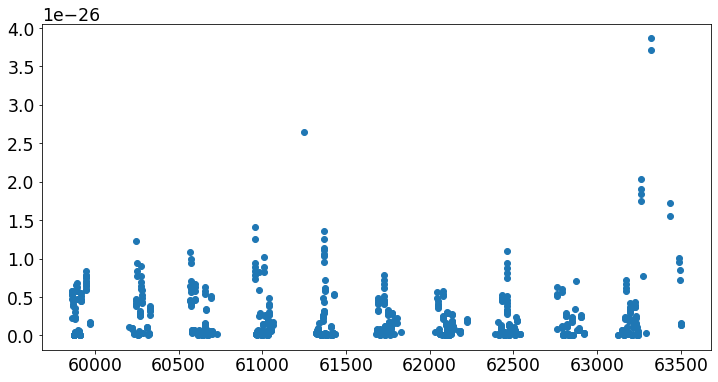

In [22]:
plt.scatter(df['observationStartMJD'], F_b)
#plt.xlim([63320,63330])

In [23]:
#import scipy.integrate as integrate
#a = 0

#for i in range (len(LSST_u.throughput)) :
    
    #a = integrate.quad(lambda Wavelength: LSST_u.throughput[i]/Wavelength, 3000, 12000)
    
#a

In [24]:
integrate.trapz(LSST_u.throughput/Wavelength)

0.006519157490141833

In [25]:
a = 0

for i in range (len(LSST_u.throughput)) :
    
    a = a + LSST_u.throughput[i]/Wavelength[i]
    
a

0.006519276406808502

In [26]:
agk_81d266 = os.path.join(os.environ['PYSYN_CDBS'], 'calspec', 'agk_81d266_stisnic_007.fits')

agk_81d266_spec = S.FileSpectrum(agk_81d266).renorm(20, 'abmag', S.ObsBandpass('johnson,v'))

agk_81d266_spec.convert('count')

(0.0, 6000.0)

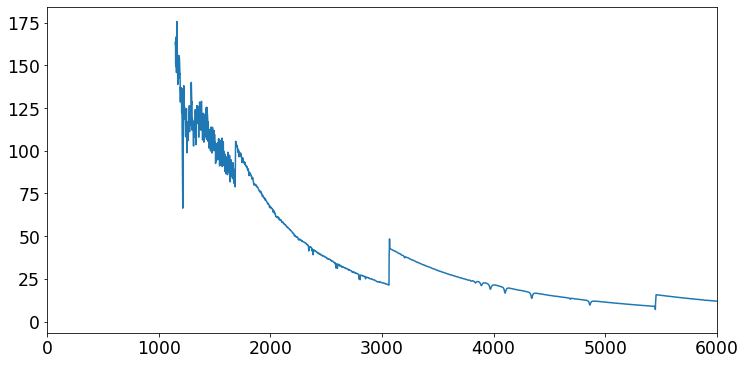

In [27]:
plt.plot(agk_81d266_spec.wave, agk_81d266_spec.flux)
plt.xlim([0,6000])

# Atmospheric throughput for every observation

In [28]:
import transmission as t

t.atmo(4959,1.2584)

0.86480181472

In [29]:
df_2018a = pd.read_csv(r'D:\Projet de recherche\Stage\Baseline_LMC_2018a_Atmosphere.csv')
df_2018a

,1,2,3,4,5,6,7,8,9,10,...,749,750,751,752,753,754,755,756,757,758
3000,0.009610,0.005305,0.006943,0.008378,0.009575,0.008064,0.009507,0.008187,0.005705,0.006884,...,0.003436,0.001133,0.001360,0.005023,0.003642,0.005570,0.008035,0.006637,0.007782,0.009401
3010,0.015317,0.008980,0.011440,0.013536,0.015266,0.013081,0.015167,0.013259,0.009581,0.011351,...,0.006081,0.002240,0.002638,0.008555,0.006402,0.009378,0.013038,0.010981,0.012673,0.015015
3020,0.022575,0.013913,0.017332,0.020177,0.022506,0.019565,0.022373,0.019804,0.014749,0.017209,...,0.009777,0.003951,0.004579,0.013324,0.010237,0.014467,0.019508,0.016694,0.019016,0.022169
3030,0.035972,0.023540,0.028544,0.032594,0.035876,0.031731,0.035688,0.032069,0.024763,0.028364,...,0.017287,0.007809,0.008878,0.022677,0.017987,0.024351,0.031650,0.027611,0.030958,0.035400
3040,0.042737,0.028594,0.034327,0.038920,0.042628,0.037945,0.042416,0.038327,0.029995,0.034121,...,0.021342,0.010046,0.011342,0.027605,0.022156,0.029522,0.037854,0.033258,0.037072,0.042090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11960,0.972918,0.969595,0.971113,0.972133,0.972896,0.971932,0.972852,0.972011,0.969966,0.971059,...,0.967204,0.961002,0.961944,0.969333,0.967481,0.969841,0.971913,0.970830,0.971752,0.972785
11970,0.972918,0.969595,0.971113,0.972133,0.972896,0.971932,0.972852,0.972011,0.969966,0.971059,...,0.967204,0.961002,0.961944,0.969333,0.967481,0.969841,0.971913,0.970830,0.971752,0.972785
11980,0.955900,0.950776,0.953109,0.954684,0.955865,0.954373,0.955798,0.954495,0.951347,0.953026,...,0.947127,0.937810,0.939215,0.950374,0.947550,0.951154,0.954344,0.952674,0.954095,0.955694
11990,0.955900,0.950776,0.953109,0.954684,0.955865,0.954373,0.955798,0.954495,0.951347,0.953026,...,0.947127,0.937810,0.939215,0.950374,0.947550,0.951154,0.954344,0.952674,0.954095,0.955694


In [30]:
bp_atmo = []

for i in range (0,758) :
    
    #if (df["observationStartMJD"].values[i] >= tmin) & (df["observationStartMJD"].values[i] <= tmax) :
        
    bp = S.ArrayBandpass(df_LSST["wl"].values*10, df_2018a.iloc[:,i].values, name = "Observation " + str(i+1))
    bp_atmo.append(bp)

In [31]:
all_bp = []

for i in range (len(bp_atmo)) :

    if (df['filter'][i] == 'u') :
        
        bp = LSST_u * bp_atmo[i]
        all_bp.append(bp)
        
    elif (df['filter'][i] == 'g') :
        
        bp = LSST_g * bp_atmo[i]
        all_bp.append(bp)
    
    elif (df['filter'][i] == 'r') :
        
        bp = LSST_r * bp_atmo[i]
        all_bp.append(bp)
    
    elif (df['filter'][i] == 'i') :
        
        bp = LSST_i * bp_atmo[i]
        all_bp.append(bp)
    
    elif (df['filter'][i] == 'z') :
        
        bp = LSST_z * bp_atmo[i]
        all_bp.append(bp)
    
    elif (df['filter'][i] == 'y') :
        
        bp = LSST_y * bp_atmo[i]
        all_bp.append(bp)

# Define the source spectrum below

In [32]:
Spec = S.Vega.renorm(20, 'abmag', S.ObsBandpass('johnson,v'))

In [33]:
all_obs = []

for bp in all_bp :
    
    obs = S.Observation(Spec, bp);
    all_obs.append(obs);

((z * Observation 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((z * Observation 88)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 89)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 90)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 91)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 92)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 93)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 94)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 95)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used i

((z * Observation 163)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 164)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 165)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 166)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 167)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 168)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 169)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 170)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((g * Observation 234)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 235)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 236)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 237)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 238)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 239)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 240)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 241)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((r * Observation 305)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 306)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 307)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 308)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 309)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 310)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 311)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 312)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((z * Observation 382)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 383)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 384)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 385)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 386)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 387)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 388)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 389)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((u * Observation 467)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 468)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 469)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 470)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 471)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 472)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 473)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 474)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((z * Observation 540)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 541)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 542)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 543)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 544)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 545)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 546)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 547)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((u * Observation 606)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 607)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 608)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 609)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 610)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 611)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 612)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 613)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((g * Observation 686)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 687)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 688)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 689)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 690)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 691)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 692)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 693)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

In [34]:
all_count = []

for obs in all_obs :
    
    all_count.append(obs.countrate())

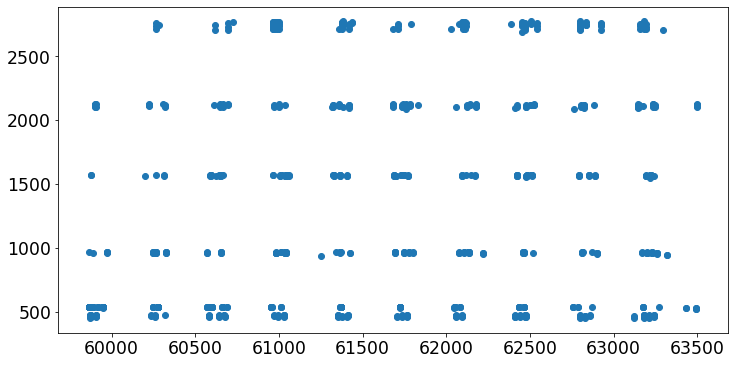

In [35]:
plt.scatter(df["observationStartMJD"], all_count)

In [36]:
#plt.scatter(df['observationStartMJD'], all_count_u, color = "b")
#plt.scatter(df['observationStartMJD'], all_count_g, color = "g")
#plt.scatter(df['observationStartMJD'], all_count_r, color = "r")
#plt.scatter(df['observationStartMJD'], all_count_i, color = "blueviolet")
#plt.scatter(df['observationStartMJD'], all_count_z, color = "grey")
#plt.scatter(df['observationStartMJD'], all_count_y, color = "k")

# Photometric error

$$
    N = \sqrt{N_{pe} + F}
$$

$$
    \sigma_N = \sqrt{N}
$$

where 

$N_{pe}$ is the background noise 

F is the source flux  

$\sigma_N$ the error

In [37]:
N = []

for i in range (len(bp_atmo)) :
    
    N.append(np.sqrt(N_pe[i] + all_count[i]))

In [38]:
sigma_N = []

for i in range (len(bp_atmo)) :
    
    sigma_N.append(np.sqrt(N[i]))

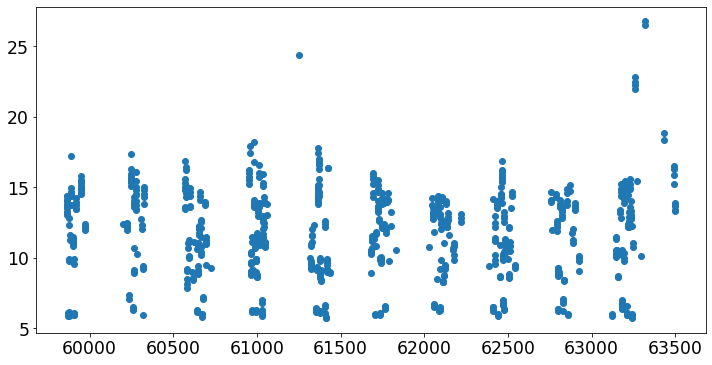

In [39]:
plt.scatter(df['observationStartMJD'], sigma_N)

<ErrorbarContainer object of 3 artists>

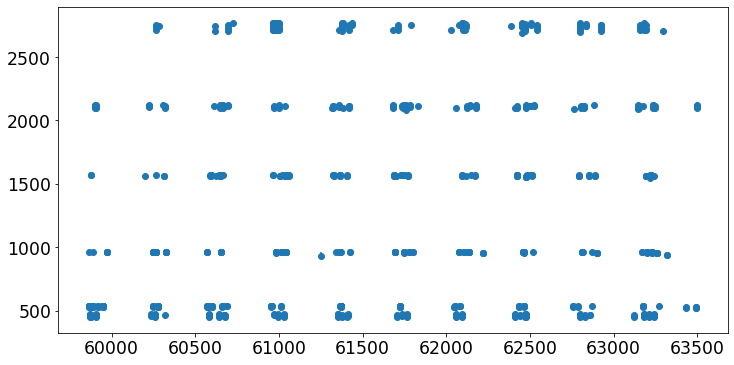

In [40]:
plt.errorbar(df['observationStartMJD'], all_count, sigma_N, fmt="o")

# Amplitude error

$$
\sigma_A = \frac{\sigma_N \times A(t)}{F}
$$

In [41]:
amp_err = []

for i in range (len(bp_atmo)) :
    
    amp_err.append(sigma_N[i] * A(u(df['observationStartMJD'][i]))/all_count[i])


(58933.90916666624, 60933.90916666624)

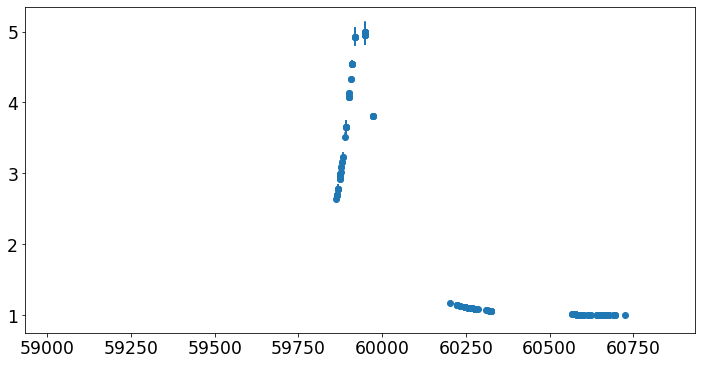

In [44]:
plt.errorbar(df['observationStartMJD'], A(u(df['observationStartMJD'])), amp_err, fmt ='o')
plt.xlim(tmin,tmax)